In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from src.transformers.load_data_unique import LoadDataUnique
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem
from src.analog_discovery.analog_discovery import AnalogDiscovery
from src.analog_discovery.mces import MCES
from src.analog_discovery.ad_multitask import ADMultitask
import copy

## params

In [5]:
MULTITASKING=True

In [6]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
#model_path = data_folder + 'best_model_multitasking_min_peaks.ckpt'
model_path = data_folder + 'best_model_multitasking_pretraining_2.ckpt'
casmi_file= '/Users/sebas/projects/data/processed_massformer/spec_df.pkl' 

In [7]:
config=Config()

In [8]:
config.D_MODEL=512
config.N_LAYERS=5


In [9]:
USE_CASMI=True

In [10]:
#similarity_name= 'simba_EDIT_DISTANCE_WITH_CONFIDENCE'
#similarity_name= 'simba_EDIT_DISTANCE'
similarity_name= 'simba_EDIT_DISTANCE_PRETRAINING'
#similarity_name= 'simba_EDIT_DISTANCE_PRETRAINING_WITHOUT_CONFIDENCE'

In [11]:
USE_MS2DEEPSCORE =False
if USE_MS2DEEPSCORE:
    similarity_name= 'simba_SIMBA_ENSEMBLED_MS2DEEPSCORE_SPEC2VEC'


In [12]:
data_folder= '/Users/sebas/projects/data/'
model_ms2d_file = data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'


In [13]:
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model
import tensorflow as tf
from matchms import calculate_scores
from src.matchms_utils import MatchmsUtils
from spec2vec import Spec2Vec

class Ms2wrapper:
    def __init__(self, model_ms2d_file):
        self.model_ms2d = load_model(model_ms2d_file)
        self.similarity_model= MS2DeepScore(self.model_ms2d)
        
    def get_predictions_ms2deepscore(self,s1, s2):
        results_ms2_all=[]
        s_query= MatchmsUtils.from_su_to_matchms(s1)
        s_ref= MatchmsUtils.from_su_to_matchms(s2)
        with tf.device('/device:CPU:0'): #execute on cpu
                results_ms2 = calculate_scores([s_query], [s_ref], self.similarity_model)
        return results_ms2.to_array()

    def compute_similarity_matrix(self,specs_su_1, specs_su_2):
        results_ms2_all=[]
        s_query= [MatchmsUtils.from_su_to_matchms(s1) for s1 in specs_su_1]
        s_ref=  [MatchmsUtils.from_su_to_matchms(s2) for s2 in specs_su_2]
        with tf.device('/device:CPU:0'): #execute on cpu
                results_ms2 = calculate_scores(s_query, s_ref, self.similarity_model)
        return results_ms2.to_array()

class Spec2vec_wrapper:
    def __init__(self, model_ms2d_file):
        self.model = gensim.models.Word2Vec.load(model_spec2vec_file)
        self.similarity_model= Spec2Vec(
                model=self.model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0
            )
    def compute_similarity_matrix(self,specs_su_1, specs_su_2):
        s_query= [MatchmsUtils.from_su_to_matchms(s1) for s1 in specs_su_1]
        s_ref=  [MatchmsUtils.from_su_to_matchms(s2) for s2 in specs_su_2]
        with tf.device('/device:CPU:0'): #execute on cpu
                results_spec2vec_all = calculate_scores(s_query, s_ref, self.similarity_model)
        return results_spec2vec_all.to_array()

In [14]:
#ms2_object=Spec2vec_wrapper(model_spec2vec_file)
ms2_object=Ms2wrapper(model_ms2d_file)

2024-09-09 11:55:04.820840: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-09-09 11:55:04.820858: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-09-09 11:55:04.820862: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-09-09 11:55:04.820897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-09 11:55:04.821068: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## open janssen data

In [17]:
if USE_CASMI:
    all_spectrums_janssen_original=LoadData.get_all_spectrums_casmi(
        casmi_file,
        config=config,
    )
else:
    loader_saver = LoaderSaver(
            block_size=100,
            pickle_nist_path='',
            pickle_gnps_path='',
            pickle_janssen_path=output_janssen_file,
        )
    all_spectrums_janssen_original = loader_saver.get_all_spectrums(
                janssen_path,
                100000000,
                use_tqdm=True,
                use_nist=False,
                config=config,
                use_janssen=True,
            )

In [18]:
all_spectrums_janssen_processed= [copy.deepcopy(s) for s in all_spectrums_janssen_original]


In [19]:
pp=Preprocessor()
### remove extra peaks in janssen
all_spectrums_janssen_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_janssen_processed]

all_spectrums_janssen = [s_original for s_original, s_processed in zip(all_spectrums_janssen_original,all_spectrums_janssen_processed) if len(s_processed.mz)>=6]

## open ref data

In [21]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [22]:
dataset['molecule_pairs_test']

In [23]:
all_spectrums_reference_original= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original


In [24]:
import copy
all_spectrums_reference_processed= [copy.deepcopy(s) for s in all_spectrums_reference_original]

In [25]:
all_spectrums_reference_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_reference_processed]
    
all_spectrums_reference = [s_original for s_original, s_processed in zip(all_spectrums_reference_original,all_spectrums_reference_processed) if len(s_processed.mz)>=6]

## Find those instances that are not in reference

In [26]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [27]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(23, 135)

In [28]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## load encoder

In [29]:
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS), multitasking=MULTITASKING, config=config)

Using cosine library from Pytorch?: True


## data loader

In [30]:
dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen)
dataloader_janssen= DataLoader(dataset_janssen, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


135it [00:00, 210.60it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [31]:
dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference)
dataloader_reference= DataLoader(dataset_reference, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


274310it [00:06, 44580.03it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [32]:
#dataset_nist= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_nist)
#dataloader_nist= DataLoader(dataset_nist, batch_size=config.BATCH_SIZE,  num_workers=0)

In [33]:
#dataset_gnps= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_gnps)
#dataloader_gnps= DataLoader(dataset_gnps, batch_size=config.BATCH_SIZE,  num_workers=0)

tensor([[0.2655, 0.1981, 0.0976,  ..., 0.0000, 0.0000, 0.0000],
        [0.1026, 0.0798, 0.1023,  ..., 0.0000, 0.0000, 0.0000],
        [0.0918, 0.1680, 0.3438,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1630, 0.2291, 0.3028,  ..., 0.0000, 0.0000, 0.0000],
        [0.1404, 0.1496, 0.1949,  ..., 0.0000, 0.0000, 0.0000],
        [0.2699, 0.2048, 0.2319,  ..., 0.0000, 0.0000, 0.0000]])


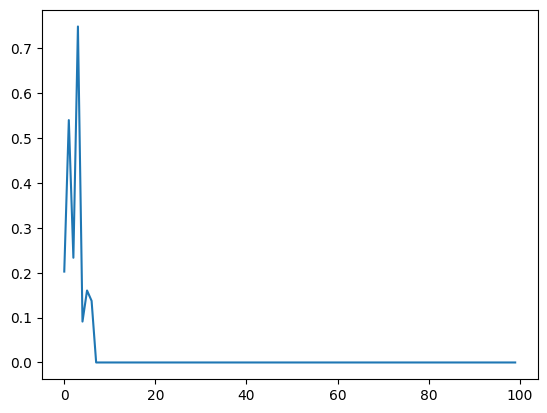

In [34]:
for batch in dataloader_reference:
    print(batch['intensity'])
    plt.plot(batch['intensity'][10])
    break

## forward

In [35]:
embeddings_janssen= encoder.get_embeddings(dataloader_janssen)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [36]:
embeddings_reference = encoder.get_embeddings(dataloader_reference)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [37]:
#embeddings_nist = encoder.get_embeddings(dataloader_nist)

In [38]:
#embeddings_gnps = encoder.get_embeddings(dataloader_gnps)

## compute similarities simba

In [39]:
similarities= CosineSimilarity.batch_cosine_similarity_combinations(embeddings_janssen, embeddings_reference)

In [40]:
similarities.shape

(135, 274310)

## compute similarities ms2deepscore

In [41]:
import copy
from src.spectrum_ext import SpectrumExt
from matchms.Spectrum import Spectrum
all_spectrums_reference_preprocessed=[]
for s in all_spectrums_reference:
    if s.mz[(s.mz >= 10) & (s.mz <= 1000)].shape[0]>0:
        all_spectrums_reference_preprocessed.append(s)
    else:
        all_spectrums_reference_preprocessed.append(all_spectrums_reference[0])

In [42]:
len(all_spectrums_reference_preprocessed), len(all_spectrums_reference)

(274310, 274310)

In [43]:
if USE_MS2DEEPSCORE:
        path_file='./similarities_ms2.npy'
        if (os.path.exists(path_file)):
            similarities_ms2=np.load(path_file)
        else:
           similarities_ms2 = ms2_object.compute_similarity_matrix(all_spectrums_janssen, all_spectrums_reference_preprocessed)

## heat map

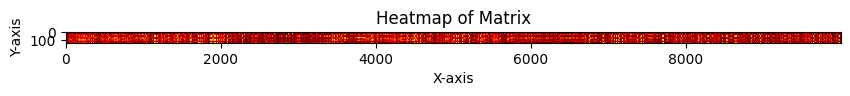

In [44]:
plt.figure(figsize=(10,100))
plt.imshow(similarities[:, 0:10000], cmap='hot', interpolation='nearest')
#plt.colorbar()  # Add colorbar to show scale
plt.title('Heatmap of Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Show PCA

In [45]:
from src.analog_discovery.pca_embeddings import PCAEmbeddings

In [46]:
pca = PCAEmbeddings()

In [47]:
pca.fit(embeddings_reference)

In [48]:
pca_ref= pca.transform(embeddings_reference)

In [49]:
pca_janssen= pca.transform(embeddings_janssen)

In [50]:
#pca_nist= pca.transform(embeddings_nist)

In [51]:
#pca_gnps= pca.transform(embeddings_gnps)

In [52]:
from src.plotting import Plotting

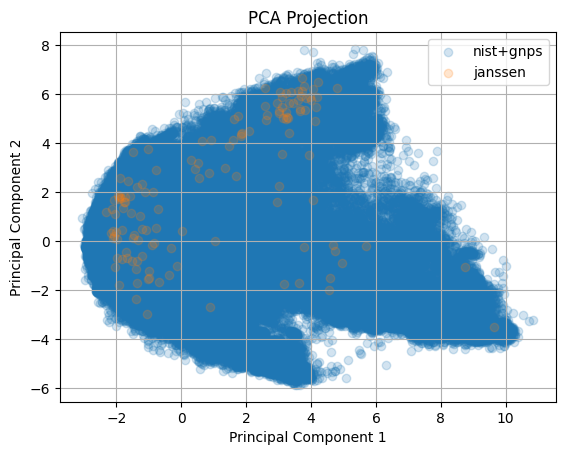

In [53]:
Plotting.plot_n_pca([pca_ref, pca_janssen,], ['nist+gnps','janssen', ], alpha=0.2)

In [54]:
similarities.shape

(135, 274310)

In [55]:
from src.tanimoto import Tanimoto
from tqdm import tqdm

In [56]:
fp_j_all = [Tanimoto.compute_fingerprint(s.params['smiles']) for s in all_spectrums_janssen]


In [57]:
fp_r_all = [Tanimoto.compute_fingerprint(s.params['smiles']) for s in all_spectrums_reference]

In [58]:
N=10000
random_j= np.random.randint(0,similarities.shape[0],N)
random_r=np.random.randint(0,similarities.shape[1],N)

In [59]:
tanimotos=np.zeros((similarities.shape[0], similarities.shape[1]))
for index_j in tqdm(random_j):
    for index_r in random_r:
        tanimotos[index_j, index_r]=Tanimoto.compute_tanimoto(fp_j_all[index_j], fp_r_all[index_r])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:48<00:00, 59.22it/s]


In [60]:
if USE_MS2DEEPSCORE:
    plt.scatter(tanimotos[random_j, random_r].reshape(-1,1), similarities_ms2[random_j, random_r].reshape(-1,1), alpha=0.2)

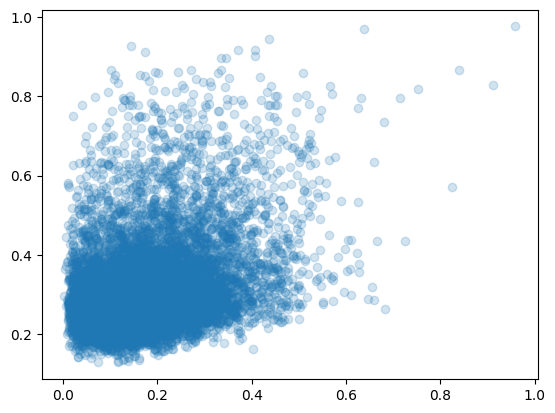

In [61]:
plt.scatter(tanimotos[random_j, random_r].reshape(-1,1), similarities[random_j, random_r].reshape(-1,1), alpha=0.2)

In [62]:
from scipy.stats import spearmanr
x=tanimotos[random_j, random_r].reshape(-1)

y=similarities[random_j, random_r].reshape(-1)

spearmanr(x,y)

SignificanceResult(statistic=0.28669291742428604, pvalue=1.7320237026609955e-188)

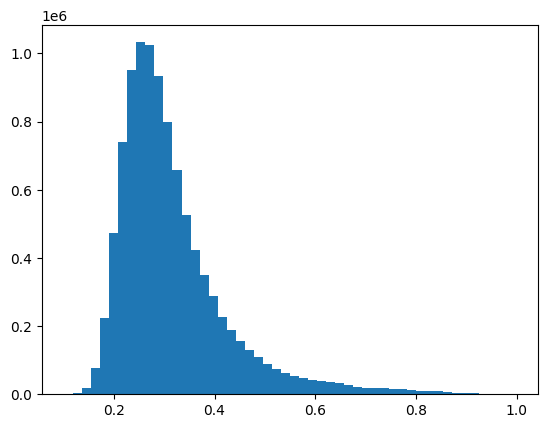

In [63]:
_=plt.hist(similarities.reshape(-1)[0:10000000],bins=50)

## Compute new similarities based on similarities of ms2deepscore and simba

In [64]:
USE_MS2DEEPSCORE

False

In [65]:
similarities_simba=similarities.copy()

In [66]:
# difference between similarities
#diff_sim = np.abs(similarities_simba-similarities_ms2)

In [68]:
#mask_matrix = (similarities_ms2 > 0.5).astype(int)

In [69]:
#mask_matrix

In [70]:
if USE_MS2DEEPSCORE:
    #similarities = similarities_simba.copy()
    similarities= (similarities_simba + similarities_ms2)/2
    similarities= similarities*mask_matrix
    #similarities = np.minimum(similarities_simba, similarities_ms2)

In [71]:
#similarities_simba[0,0],similarities_ms2[0,0],similarities[0,0]

## Based on the similarities compute the similarity score of the match spectrum

In [72]:
spectrums_k_retrieved, tanimoto_k_retrieved, sim_k_retrieved, arg_max_k10 =\
                AnalogDiscovery.get_k_candidates(similarities, all_spectrums_reference, 
                                                 all_spectrums_janssen,k=10, return_arg_max_k10=True)

In [73]:
if USE_MS2DEEPSCORE:
    similarities_simba_k_retrieved=  np.take_along_axis(similarities_simba, arg_max_k10, axis=1)
    similarities_ms2_k_retrieved=  np.take_along_axis(similarities_ms2, arg_max_k10, axis=1)
    #index=-1
    #for sim_total, simba, ms2, tani in zip(sim_k_retrieved[index], similarities_simba_k_retrieved[index], similarities_ms2_k_retrieved[index], tanimoto_k_retrieved[index]):
    #    print(f'S:{simba},MS2: {ms2},TOTAL: {sim_total} TANI:{tani}\n')

In [74]:
## For the k spectrums retrieved, calculate the edit distance

In [75]:
ad_multitask= ADMultitask(model_path, config=config)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [76]:
edit_distance_k= ad_multitask.get_edit_distance_all(all_spectrums_janssen, spectrums_k_retrieved )

0it [00:00, ?it/s]

Preprocessing all the data ...



11it [00:00, 31796.93it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
1it [00:00,  5.22it/s]

Preprocessing all the data ...



11it [00:00, 25575.02it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 8493.62it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
3it [00:00,  9.89it/s]

Preprocessing all the data ...



11it [00:00, 25703.26it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 18366.78it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
5it [00:00, 11.89it/s]

Preprocessing all the data ...



11it [00:00, 28515.05it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 32908.23it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
7it [00:00, 13.01it/s]

Preprocessing all the data ...



11it [00:00, 31068.92it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30656.04it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
9it [00:00, 13.69it/s]

Preprocessing all the data ...



11it [00:00, 31818.86it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 32173.88it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
11it [00:00, 14.23it/s]

Preprocessing all the data ...



11it [00:00, 34277.37it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 36529.96it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
13it [00:00, 14.77it/s]

Preprocessing all the data ...



11it [00:00, 17189.77it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30037.33it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
15it [00:01, 15.10it/s]

Preprocessing all the data ...



11it [00:00, 30554.53it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30902.44it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
17it [00:01, 15.44it/s]

Preprocessing all the data ...



11it [00:00, 17973.25it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 35165.66it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
19it [00:01, 15.57it/s]

Preprocessing all the data ...



11it [00:00, 31709.51it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 33825.03it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
21it [00:01, 15.70it/s]

Preprocessing all the data ...



11it [00:00, 34952.53it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 39876.70it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
23it [00:01, 15.90it/s]

Preprocessing all the data ...



11it [00:00, 30293.73it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31428.71it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
25it [00:01, 15.80it/s]

Preprocessing all the data ...



11it [00:00, 33049.67it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 15404.79it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
27it [00:01, 15.60it/s]

Preprocessing all the data ...



11it [00:00, 26824.04it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 29575.22it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
29it [00:02, 15.56it/s]

Preprocessing all the data ...



11it [00:00, 36300.03it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 33949.48it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
31it [00:02, 15.79it/s]

Preprocessing all the data ...



11it [00:00, 34585.72it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 13613.85it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
33it [00:02, 15.97it/s]

Preprocessing all the data ...



11it [00:00, 38351.91it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 29881.70it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
35it [00:02, 16.04it/s]

Preprocessing all the data ...



11it [00:00, 33627.80it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31973.21it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
37it [00:02, 16.08it/s]

Preprocessing all the data ...



11it [00:00, 36328.62it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30056.90it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
39it [00:02, 16.13it/s]

Preprocessing all the data ...



11it [00:00, 28799.84it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 27495.44it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
41it [00:02, 16.25it/s]

Preprocessing all the data ...



11it [00:00, 33750.80it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31258.36it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
43it [00:02, 16.34it/s]

Preprocessing all the data ...



11it [00:00, 35381.40it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 34794.38it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
45it [00:02, 16.16it/s]

Preprocessing all the data ...



11it [00:00, 28064.08it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 34508.11it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
47it [00:03, 16.24it/s]

Preprocessing all the data ...



11it [00:00, 36271.50it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 36072.98it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
49it [00:03, 16.51it/s]

Preprocessing all the data ...



11it [00:00, 29499.58it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31579.29it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
51it [00:03, 16.46it/s]

Preprocessing all the data ...



11it [00:00, 37028.37it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30293.73it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
53it [00:03, 16.47it/s]

Preprocessing all the data ...



11it [00:00, 29480.73it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 34353.94it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
55it [00:03, 16.51it/s]

Preprocessing all the data ...



11it [00:00, 33336.23it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 29330.80it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
57it [00:03, 16.47it/s]

Preprocessing all the data ...



11it [00:00, 33336.23it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31796.93it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
59it [00:03, 16.45it/s]

Preprocessing all the data ...



11it [00:00, 31152.83it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 36558.91it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
61it [00:03, 16.49it/s]

Preprocessing all the data ...



11it [00:00, 38351.91it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 26622.82it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
63it [00:04, 16.49it/s]

Preprocessing all the data ...



11it [00:00, 29959.31it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 29237.86it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
65it [00:04, 16.49it/s]

Preprocessing all the data ...



11it [00:00, 34049.70it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 15343.31it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
67it [00:04, 15.95it/s]

Preprocessing all the data ...



11it [00:00, 29256.40it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 27561.14it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
69it [00:04, 15.94it/s]

Preprocessing all the data ...



11it [00:00, 30293.73it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 23648.05it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
71it [00:04, 16.03it/s]

Preprocessing all the data ...



11it [00:00, 30737.74it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31343.30it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
73it [00:04, 16.17it/s]

Preprocessing all the data ...



11it [00:00, 24554.20it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 29424.33it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
75it [00:04, 16.28it/s]

Preprocessing all the data ...



11it [00:00, 34508.11it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 36529.96it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
77it [00:04, 16.36it/s]

Preprocessing all the data ...



11it [00:00, 30985.46it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 27348.75it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
79it [00:05, 16.40it/s]

Preprocessing all the data ...



11it [00:00, 33026.02it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 27776.85it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
81it [00:05, 16.40it/s]

Preprocessing all the data ...



11it [00:00, 35354.29it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 28339.89it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
83it [00:05, 16.32it/s]

Preprocessing all the data ...



11it [00:00, 32955.25it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 33120.85it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
85it [00:05, 16.37it/s]

Preprocessing all the data ...



11it [00:00, 32354.38it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30554.53it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
87it [00:05, 16.43it/s]

Preprocessing all the data ...



11it [00:00, 31450.13it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 24606.58it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
89it [00:05, 16.42it/s]

Preprocessing all the data ...



11it [00:00, 33336.23it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 33849.85it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
91it [00:05, 16.15it/s]

Preprocessing all the data ...



11it [00:00, 27364.97it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 17663.61it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
93it [00:05, 16.07it/s]

Preprocessing all the data ...



11it [00:00, 32263.88it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 33726.13it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
95it [00:06, 16.21it/s]

Preprocessing all the data ...



11it [00:00, 32955.25it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 36646.02it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
97it [00:06, 16.31it/s]

Preprocessing all the data ...



11it [00:00, 36186.15it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31258.36it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
99it [00:06, 16.16it/s]

Preprocessing all the data ...



11it [00:00, 27928.17it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 6311.54it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
101it [00:06, 15.45it/s]

Preprocessing all the data ...



11it [00:00, 28871.93it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 34899.66it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
103it [00:06, 15.67it/s]

Preprocessing all the data ...



11it [00:00, 28926.23it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31995.38it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
105it [00:06, 15.89it/s]

Preprocessing all the data ...



11it [00:00, 29405.57it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 33144.64it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
107it [00:06, 16.18it/s]

Preprocessing all the data ...



11it [00:00, 30717.27it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30881.76it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
109it [00:06, 16.16it/s]

Preprocessing all the data ...



11it [00:00, 32468.22it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 28287.76it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
111it [00:07, 16.12it/s]

Preprocessing all the data ...



11it [00:00, 23855.92it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 25703.26it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
113it [00:07, 16.19it/s]

Preprocessing all the data ...



11it [00:00, 27710.12it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 26777.33it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
115it [00:07, 16.27it/s]

Preprocessing all the data ...



11it [00:00, 33652.33it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 32768.00it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
117it [00:07, 16.25it/s]

Preprocessing all the data ...



11it [00:00, 29405.57it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 27219.67it/s]
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
119it [00:07, 16.08it/s]

Preprocessing all the data ...



11it [00:00, 28064.08it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30902.44it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
121it [00:07, 16.14it/s]

Preprocessing all the data ...



11it [00:00, 32445.39it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 30902.44it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
123it [00:07, 16.25it/s]

Preprocessing all the data ...



11it [00:00, 33750.80it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 22638.54it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
125it [00:07, 16.37it/s]

Preprocessing all the data ...



11it [00:00, 29959.31it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31152.83it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
127it [00:08, 16.41it/s]

Preprocessing all the data ...



11it [00:00, 34899.66it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31258.36it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
129it [00:08, 16.44it/s]

Preprocessing all the data ...



11it [00:00, 28638.95it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 31579.29it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
131it [00:08, 16.43it/s]

Preprocessing all the data ...



11it [00:00, 29575.22it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 20024.89it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
133it [00:08, 16.37it/s]

Preprocessing all the data ...



11it [00:00, 28710.23it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Preprocessing all the data ...



11it [00:00, 29727.67it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
135it [00:08, 15.85it/s]


In [77]:
edit_distance_k[24]

array([[5.36562817e-04, 1.14743598e-02, 2.88498420e-02, 7.02790245e-02,
        1.76338479e-01, 7.12521791e-01],
       [3.91115143e-04, 1.03900554e-02, 2.69129332e-02, 6.53905794e-02,
        1.88790888e-01, 7.08124399e-01],
       [5.00036287e-04, 1.42949447e-02, 3.51531319e-02, 7.77885243e-02,
        2.20260173e-01, 6.52003169e-01],
       [6.44274114e-04, 1.30483564e-02, 3.10791973e-02, 7.49319121e-02,
        2.04573050e-01, 6.75723195e-01],
       [5.22214337e-04, 1.15775475e-02, 3.00291590e-02, 7.17530027e-02,
        1.80244148e-01, 7.05873966e-01],
       [5.93878096e-04, 1.09776845e-02, 2.83655412e-02, 7.25429058e-02,
        1.54975086e-01, 7.32544899e-01],
       [4.32990841e-04, 1.40950559e-02, 3.53955179e-02, 8.00510868e-02,
        2.12993205e-01, 6.57032132e-01],
       [8.03104893e-04, 1.45862401e-02, 3.52874771e-02, 8.13777745e-02,
        2.12991506e-01, 6.54953897e-01],
       [5.52349782e-04, 1.47789028e-02, 3.43901701e-02, 7.06144795e-02,
        2.02283457e-01, 

In [78]:
# get the confidence of the first prediction
confidence_k= [[ed[0] for ed in ed_group]for ed_group in edit_distance_k]

In [79]:
# based on the difference between m0 and m1
#confidence_k = [[abs(m-s)/max(m,s) for s,m in zip(simba_group, ms2_group)]for simba_group, ms2_group in zip(similarities_simba_k_retrieved, similarities_ms2_k_retrieved)]

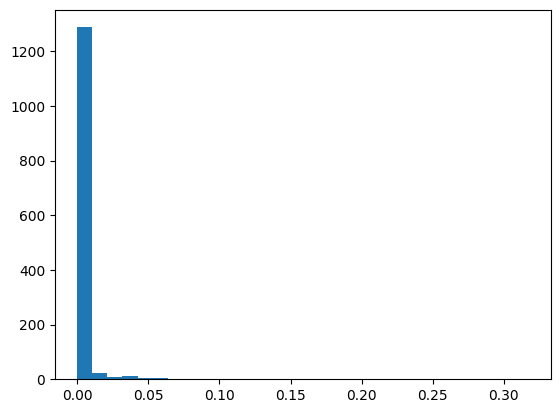

In [80]:
all_low = np.concatenate(confidence_k)
_=plt.hist(all_low, bins=30)

In [81]:
#ms2_deepscore_k= [[ms2_object.get_predictions_ms2deepscore(s,s_query) for s in s_group_k] for s_group_k, s_query in zip(spectrums_k_retrieved, all_spectrums_janssen)]

In [82]:
## metric based on ms2deepscore
#new_metric_not_collapsed= [[ (sim, ms2, tani, spec.params['smiles']) \
#               for sim, ms2, tani, spec in zip(sim_group, ms2_group, tani_group, spec_group )] \
#               for sim_group, ms2_group, tani_group, spec_group  in zip(sim_k_retrieved, ms2_deepscore_k, tanimoto_k_retrieved, spectrums_k_retrieved) \
#                ]

In [83]:
#new_metric = [[ float((m[0])/2) for m in m_group] for m_group in new_metric_not_collapsed]
#new_metric = [[ float((m[0]+m[1])/2)  for m in m_group] for m_group in new_metric_not_collapsed]


In [84]:
# create a new metric based on tanimoto and edit distance
#categories= np.array([0,1,2,3,4,5])/5
#new_metric= [ [ (sim +  (1-edit_distance[0]) + (np.argmax(edit_distance))/5  )/3 \
#new_metric= [[ ( sim )/2 \
#new_metric= [[ ( sim + (np.argmax(edit_distance))/5)/2 \
#new_metric= [[ ( sim + np.sum(categories*edit_distance))/2 \
#               for sim, edit_distance in zip(sim_group, edit_distance_group)] \
#               for sim_group, edit_distance_group in zip(sim_k_retrieved, edit_distance_k) \
#                ]
#
#new_metric= [ [ (sim + np.sum(categories*edit_distance))/2 for sim, edit_distance in zip(sim_group, edit_distance_group)] \
#                for sim_group, edit_distance_group in zip(sim_k_retrieved, edit_distance_k)]
#new_metric

In [99]:
good_k_indexes= [[i for i,c in enumerate(c_group) if c<1] for c_group in confidence_k ]
#good_k_indexes= [[i for i,c in enumerate(c_group) if c<0.001] for c_group in confidence_k ]
#good_k_indexes = [[i for i,c in enumerate(c_group) if c<1] for c_group in confidence_k ]
#good_k_indexes= [list(np.flip(np.argsort(m_group))) for m_group in new_metric]


# if there are no good indexes no filter
#good_k_indexes= [index_group if len(index_group)>0 else list(range(0,10)) for index_group in good_k_indexes]


In [100]:
filt_spectrums_k_retrieved = [[ spectrums_k_retrieved[k][ind]  for ind in index_group]  for k,index_group in enumerate(good_k_indexes)]
filt_tanimoto_k_retrieved = [[  tanimoto_k_retrieved[k][ind] for ind in index_group]  for k,index_group in enumerate(good_k_indexes)]
filt_sim_k_retrieved = [[ sim_k_retrieved[k][ind] for ind in index_group]  for k,index_group in enumerate(good_k_indexes)]
filt_edit_distance_k_retrieved = [[ edit_distance_k[k][ind] for ind in index_group]  for k,index_group in enumerate(good_k_indexes)]

In [101]:
best_indexes = [np.argmax(tani_group[0:10]) if len(tani_group)>=1 else None for tani_group in filt_tanimoto_k_retrieved ]

In [102]:
# get the best tanimotos
spectrums_retrieved = [filt_spectrums_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]
tanimoto_retrieved = [filt_tanimoto_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]
max_sim = [filt_sim_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]
edit_distance=[filt_edit_distance_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]

In [103]:
smiles_retrieved= [s.smiles for s in spectrums_retrieved]

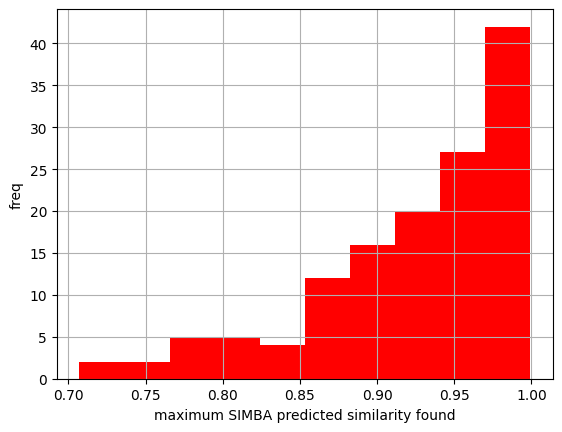

In [104]:
_=plt.hist(max_sim, color='r', bins=10)
plt.xlabel('maximum SIMBA predicted similarity found')
plt.ylabel('freq')
plt.grid()

In [105]:
len(tanimoto_retrieved)

135

(0.0, 3.5)

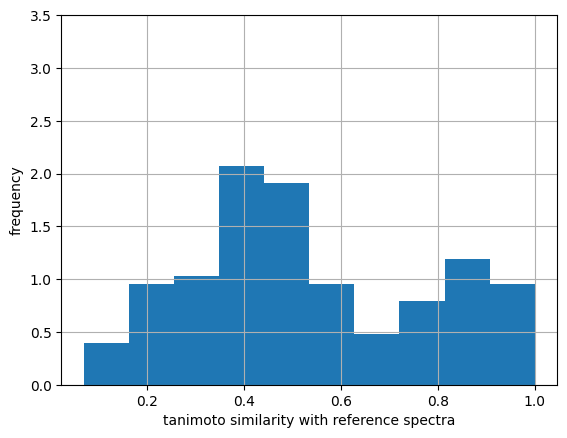

In [106]:
plt.hist(tanimoto_retrieved,density=True, bins=10)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')
plt.ylim([0,3.5])

In [107]:
tanimoto_retrieved=np.array(tanimoto_retrieved)
tanimoto_retrieved[tanimoto_retrieved<0.80].shape[0]/tanimoto_retrieved.shape[0]

0.7925925925925926

In [108]:
np.median(tanimoto_retrieved)

0.4761491760624458

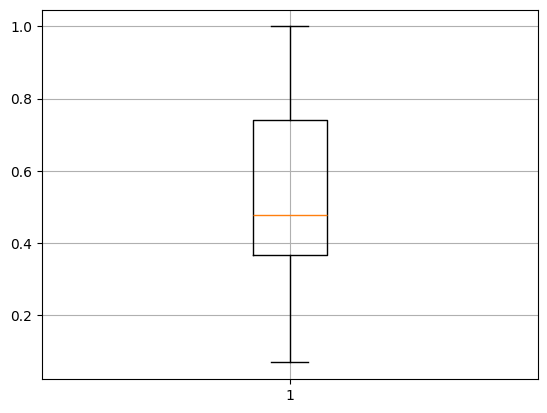

In [109]:
plt.boxplot(tanimoto_retrieved)
plt.grid()

## Check which is the spectra that has wrong predictions

In [411]:
target_index=-4

In [412]:
diff_tanimoto =abs(np.array(tanimoto_retrieved)-np.array(max_sim))
bad_predictions=np.argsort(diff_tanimoto)[::-1]
#bad_predictions=np.argsort(abs(np.array(max_sim)))

In [413]:
precursor_mass_query= [all_spectrums_janssen[bad_predictions[i]].params['pepmass'][0] for i in range(0,len(all_spectrums_janssen))]
precursor_mass_retrieved= [spectrums_retrieved[bad_predictions[i]].params['pepmass'][0] for i in range(0,len(all_spectrums_janssen))]

In [414]:
diff_tanimoto_ordered= [diff_tanimoto[bad_predictions[i]] for i in range(0,len(all_spectrums_janssen))]

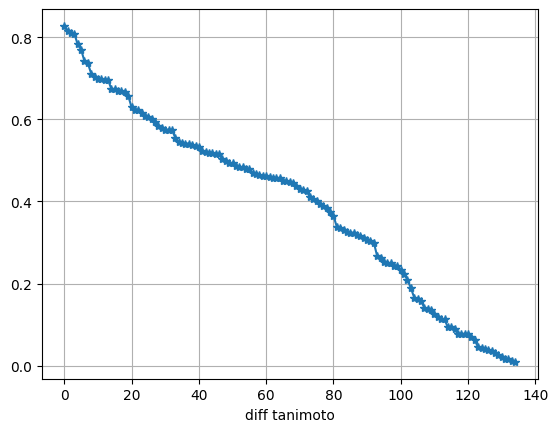

In [415]:
plt.plot(diff_tanimoto_ordered, marker="*")
plt.xlabel('diff tanimoto')
plt.grid()

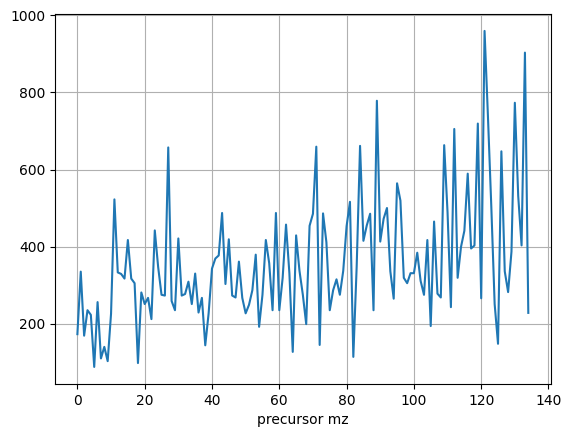

In [416]:
plt.plot(precursor_mass_query)
plt.xlabel('precursor mz')
plt.grid()

In [417]:
precursor_mass_ref= [s.params['pepmass'][0] for s in all_spectrums_reference]

Text(0.5, 0, 'precursor_mass')

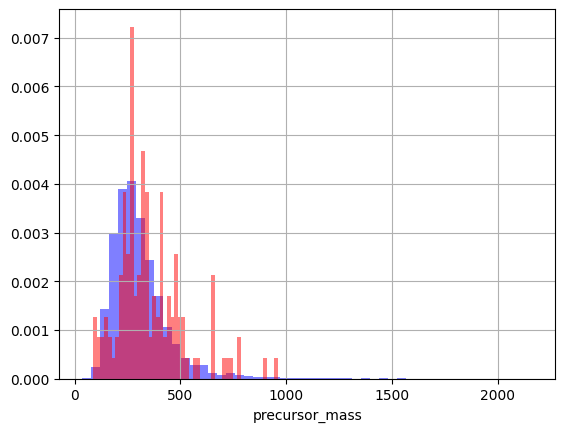

In [418]:
plt.hist(precursor_mass_ref, label='reference', bins=50, color='b',alpha=0.5, density=True)
plt.hist(precursor_mass_query, label='query', bins=50, color='r',alpha=0.5, density=True)
plt.grid()
plt.xlabel('precursor_mass')

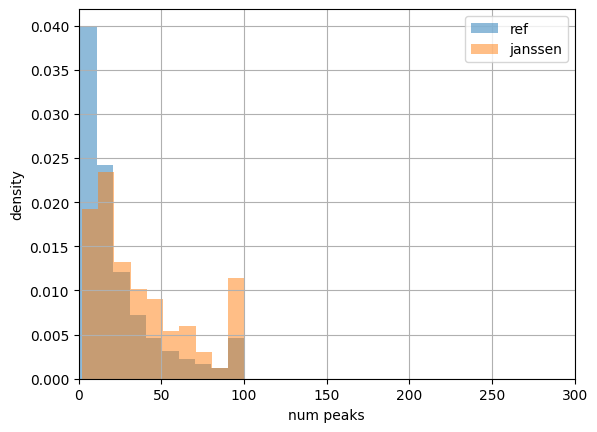

In [419]:
number_peaks_ref= np.array([len(s.mz) for s in all_spectrums_reference_processed])
number_peaks_query= np.array([len(s.mz) for s in all_spectrums_janssen_processed])
_=plt.hist(number_peaks_ref, bins=10, density=True, alpha=0.5,label='ref')
_=plt.hist(number_peaks_query, bins=10, density=True, alpha=0.5, label='janssen')
plt.ylabel('density')
plt.xlabel('num peaks')
plt.xlim([0,300])
plt.legend()
plt.grid()

In [420]:
number_peaks_ref[number_peaks_ref<10].shape[0]/number_peaks_ref.shape[0]

0.3574050357552101

In [421]:
number_peaks_query[number_peaks_query<10].shape[0]/number_peaks_query.shape[0]

0.1588235294117647

In [422]:
target_spectra=bad_predictions[target_index]

In [423]:
all_spectrums_janssen[target_spectra].params

{'spectrumid': '238 M+H',
 'name': '238 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 238,
 'smiles': 'CCCCCCCCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCCCCCCC',
 'ionmode': 'Positive',
 'pepmass': [531.4400905022],
 'charge': [1],
 'libraryquality': 1}

In [424]:
all_spectrums_janssen[target_spectra].mz

array([ 57.07003403,  57.59871292,  59.50532913,  71.08556366,
        81.82245636,  85.10127258, 110.8960037 , 149.0228119 ,
       187.8656311 , 215.1038818 , 222.9974365 , 253.9098053 ,
       540.6230469 ])

In [425]:
all_spectrums_janssen[target_spectra].intensity/max(all_spectrums_janssen[target_spectra].intensity)

array([0.9491623 , 0.07576486, 0.07018135, 0.947759  , 0.07693042,
       0.61539644, 0.06826252, 1.        , 0.07245623, 0.574471  ,
       0.09591162, 0.09474979, 0.08907014], dtype=float32)

In [426]:
spectrums_retrieved[target_spectra].params

{'pepmass': (391.3, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'ESI-QQQ',
 'filename': 'MSV000078658/ccms_peak/s102-v758.mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-NIST14-MATCHES',
 'name': 'Spectral Match to Dioctyl phthalate from NIST14 M+H',
 'pi': 'Data from Maria Maansson',
 'datacollector': 'Data deposited by marjo',
 'smiles': 'CCCCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCCC',
 'inchi': 'InChI=1S/C24H38O4/c1-3-5-7-9-11-15-19-27-23(25)21-17-13-14-18-22(21)24(26)28-20-16-12-10-8-6-4-2/h13-14,17-18H,3-12,15-16,19-20H2,1-2H3',
 'inchiaux': 'N/A',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '3',
 'spectrumid': 'CCMSLIB00003138374',
 'scans': '1933'}

In [427]:
max(all_spectrums_janssen[0].intensity)

781297.7

In [428]:
max(spectrums_retrieved[6].intensity)

999.0

In [429]:
len(spectrums_retrieved[target_spectra].mz)

10

In [430]:
len(all_spectrums_janssen[target_spectra].mz)

13

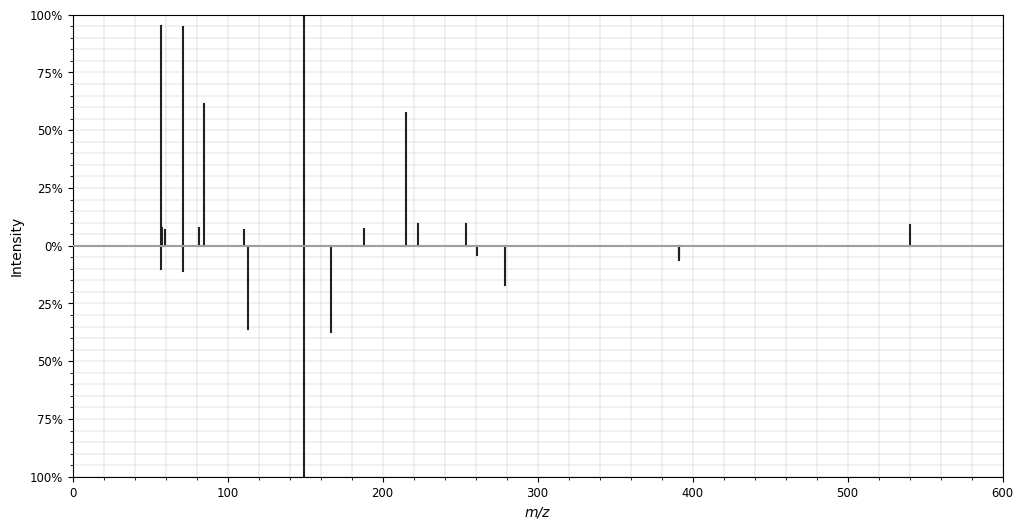

In [431]:
Plotting.plot_mirror_plot( all_spectrums_janssen[target_spectra],spectrums_retrieved[target_spectra])

In [432]:
## pass through preprocessing:
pp=Preprocessor()
import copy

spectrum_copy= copy.deepcopy(spectrums_retrieved[target_spectra])
spectrum_copy=pp.preprocess_spectrum(spectrum_copy)

In [433]:
len(spectrums_retrieved[target_spectra].intensity)

10

In [434]:
len(max_sim)

135

In [435]:
max_sim[target_spectra]

0.9845977

In [436]:
tanimoto_retrieved[target_spectra]

1.0

<BarContainer object of 6 artists>

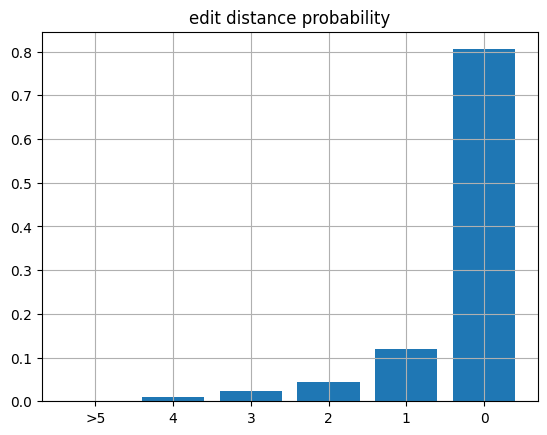

In [437]:
##plot edit distance
plt.title('edit distance probability')
plt.grid()
plt.bar(x=['>5','4','3','2','1','0'], height=edit_distance[target_spectra])

In [438]:
edit_distance[target_spectra]

array([6.25403118e-05, 9.88828298e-03, 2.25440692e-02, 4.31681685e-02,
       1.18966974e-01, 8.05369914e-01], dtype=float32)

In [439]:
sim_mces = MCES.calculate_mces_sim(smiles1=all_spectrums_janssen[target_spectra].params['smiles'], 
                         smiles2=spectrums_retrieved[target_spectra].params['smiles'])
sim_mces

0.7368421052631579

In [440]:
Chem.CanonSmiles(all_spectrums_janssen[target_spectra].params['smiles'])

'CCCCCCCCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCCCCCCC'

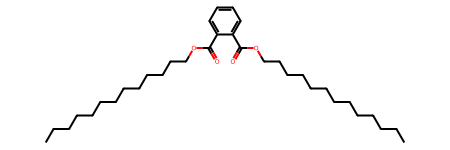

In [441]:
from rdkit import Chem
mol_janssen = Chem.MolFromSmiles(all_spectrums_janssen[target_spectra].params['smiles'])
mol_janssen

In [442]:
Chem.CanonSmiles(spectrums_retrieved[target_spectra].params['smiles'])

'CCCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCC'

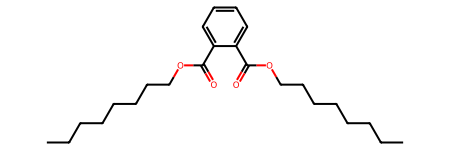

In [443]:
mol_ref = Chem.MolFromSmiles(spectrums_retrieved[target_spectra].params['smiles'])
mol_ref

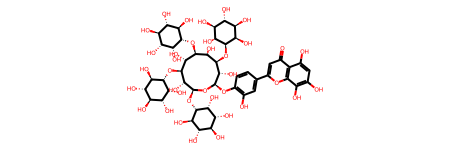

In [377]:
temp_smiles='C1=CC(=C(C=C1C2=CC(=O)C3=C(O2)C(=C(C=C3O)O)O)O)[O][C@@H]4[C@@H](O)[C@H](O[C@H]5[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)[C@H]5O)[C@@H](O)[C@H](O[C@H]6[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)[C@H]6O)[C@@H](O)[C@H](O[C@H]7[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)[C@H]7O)[C@@H](O)[C@H](O[C@H]8[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)[C@H]8O)O4'
Chem.MolFromSmiles(temp_smiles)

In [342]:
Tanimoto.compute_tanimoto_from_smiles(all_spectrums_janssen[target_spectra].params['smiles'], temp_smiles)

0.7490170380078637

## Explainability

In [141]:
from src.transformers.sklearn_model import SklearnModel
sklearn_model = SklearnModel(model_loaded=ad_multitask.multitask_model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [142]:
#explainer=sklearn_model.get_explainer(dataset['molecule_pairs_test'])

## Output of MS2Deepscore

In [143]:
## BAD PREDICTIONS

results_simba_all=[]
results_tanimoto_all=[]

results_ms2_all=[]
for index in range(0,20):
    #get the index of the bad spectra
    t=bad_predictions[index]

    # get the tanimoto ground truth
    results_tanimoto_all.append(tanimoto_retrieved[t])

    # get the results of simba
    results_simba_all.append(max_sim[t])
    results_ms2_all.append(ms2_object.get_predictions_ms2deepscore(all_spectrums_janssen[t], spectrums_retrieved[t]))

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step



2024-09-09 14:22:37.535969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step



Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 14ms/step



Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step



Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


In [343]:
results_ms2_all

[array([[0.31414176]]),
 array([[0.34241951]]),
 array([[0.87005907]]),
 array([[0.89657713]]),
 array([[0.88720902]]),
 array([[0.32392165]]),
 array([[0.58040734]]),
 array([[0.46739375]]),
 array([[0.8470676]]),
 array([[0.17851302]]),
 array([[0.72181167]]),
 array([[0.1887252]]),
 array([[0.77943309]]),
 array([[0.78571571]]),
 array([[0.34469769]]),
 array([[0.42845111]]),
 array([[0.74195501]]),
 array([[0.94050198]]),
 array([[0.67679676]]),
 array([[0.49827624]])]

Text(0, 0.5, 'MS2Deepscore pred')

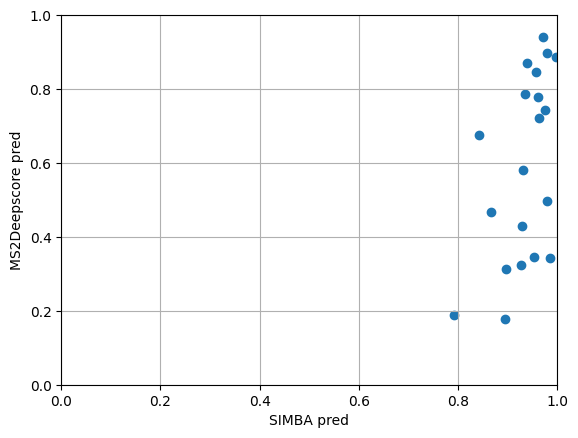

In [145]:
plt.scatter(results_simba_all, results_ms2_all)
plt.ylim([0,1])
plt.xlim([0,1])
plt.grid()
plt.xlabel('SIMBA pred')
plt.ylabel('MS2Deepscore pred')

Text(0, 0.5, 'MS2Deepscore pred')

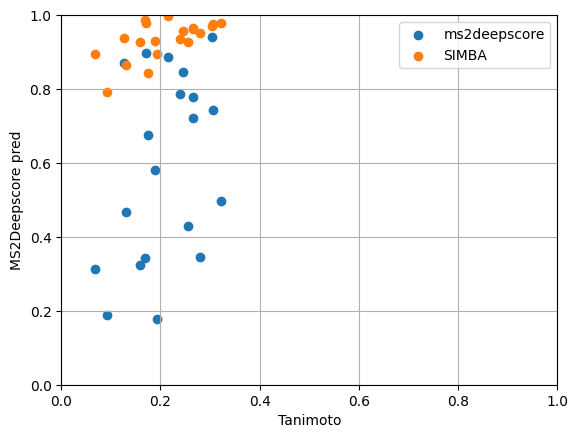

In [146]:
plt.scatter(results_tanimoto_all, results_ms2_all, label='ms2deepscore')
plt.scatter(results_tanimoto_all, results_simba_all, label='SIMBA')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,1])
plt.grid()
plt.xlabel('Tanimoto')
plt.ylabel('MS2Deepscore pred')

## FIND SIMILARITY BASED ON MCES

In [147]:
smiles_janssen = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]

In [148]:
len(smiles_retrieved)

135

In [149]:
len(smiles_janssen)

135

In [150]:
mces_sims=[]
for s0,s1 in tqdm(zip(smiles_janssen, smiles_retrieved)):
    similarity= MCES.calculate_mces_sim(s0, s1)
    mces_sims.append(similarity)

0it [00:00, ?it/s]Too many matching bond pairs (1108) so can't continue.
Too many matching bond pairs (1107) so can't continue.
41it [00:01, 19.61it/s]Too many matching bond pairs (1020) so can't continue.
Too many matching bond pairs (1154) so can't continue.
80it [00:01, 49.87it/s]Too many matching bond pairs (1041) so can't continue.
Too many matching bond pairs (1348) so can't continue.
Too many matching bond pairs (1148) so can't continue.
101it [01:03,  1.36s/it]

Timed out after 61 seconds.


Too many matching bond pairs (1046) so can't continue.
Too many matching bond pairs (1584) so can't continue.
Too many matching bond pairs (2859) so can't continue.
135it [01:08,  1.98it/s]


In [151]:
# Specify the bin width
bin_width = 0.1

# Calculate the number of bins based on the data range and bin width
bins = np.arange(0, 1 + bin_width, bin_width)

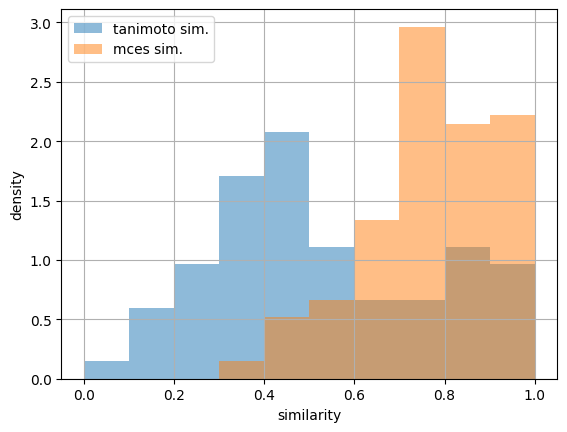

In [152]:
plt.hist(tanimoto_retrieved,alpha=0.5, label='tanimoto sim.', density=True, bins=bins)
plt.hist([m for m in mces_sims if m is not None],alpha=0.5, label='mces sim.', density=True, bins=bins)
plt.xlabel('similarity')
plt.ylabel('density')
plt.legend()
plt.grid()

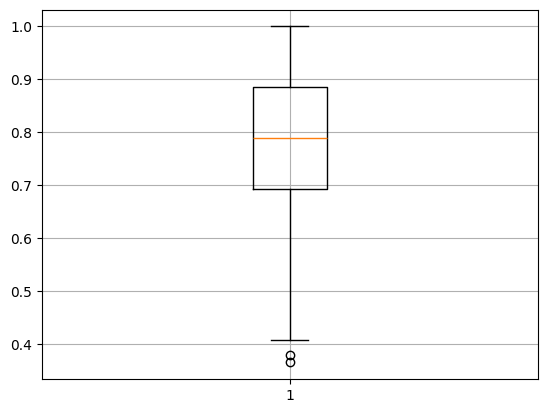

In [153]:
plt.boxplot([m for m in mces_sims if m is not None])
plt.grid()

## Rankings

In [154]:
format_file_unknown = "./notebooks/discovery_search/results/{}_results_analog_discovery_unknwon_compounds.pkl"

if USE_CASMI:
    file= format_file_unknown.format('tanimoto_similarity_casmi')
else:
    file= format_file_unknown.format('tanimoto_similarity')
with open(file, 'rb') as f:
        results_tani = dill.load(f)

In [155]:
## load the tanimoto similarity data
## get the indexes in the reference data
smiles_best_candidate_loaded = [Chem.CanonSmiles(s) for s in results_tani['smiles_retrieved']]
smiles_reference_loaded = [Chem.CanonSmiles(s) for s in results_tani['smiles_reference']]
smiles_janssen_loaded = [Chem.CanonSmiles(s) for s in results_tani['smiles_janssen']]

In [156]:
#list_rankings=[]

In [157]:
#list_rankings=[]
list_rankings=AnalogDiscovery.get_rank_of_best_candidate(similarities, smiles_janssen, smiles_janssen_loaded, smiles_reference, smiles_best_candidate_loaded)

The best candidate is not found in the current reference data. Possibly this is spectra was filtered out
The best candidate is not found in the current reference data. Possibly this is spectra was filtered out
The best candidate is not found in the current reference data. Possibly this is spectra was filtered out
The best candidate is not found in the current reference data. Possibly this is spectra was filtered out
The best candidate is not found in the current reference data. Possibly this is spectra was filtered out


## saving of results

In [158]:
len(max_sim), len(tanimoto_retrieved), len(all_spectrums_janssen), len(smiles_retrieved), len(mces_sims), len(smiles_janssen), len(spectrums_retrieved)

(135, 135, 135, 135, 135, 135, 135)

In [159]:
results ={ 'preprocessed_all_spectrums_janssen':all_spectrums_janssen,
            'smiles_janssen':smiles_janssen,
          'smiles_retrieved':smiles_retrieved,
          'spectrums_retrieved':spectrums_retrieved,
            'tanimoto_retrieved':tanimoto_retrieved,
          'max_sim':max_sim,
          'mces_retrieved':mces_sims,
          'smiles_reference': smiles_reference,
          'list_rankings':list_rankings,
         'similarities': similarities,
          'preprocessed_all_spectrums_reference':all_spectrums_reference,
         }

In [160]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_unknwon_compounds.pkl', 'wb') as f:
    dill.dump(results, f)

In [161]:
similarity_name

'simba_EDIT_DISTANCE_PRETRAINING'